In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,528
Trainable params: 18,432,400
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.7586 - acc: 0.1799
Epoch 00001: val_loss improved from inf to 13.25686, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_BN_checkpoint/001-13.2569.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 12.7586 - acc: 0.1799 - val_loss: 13.2569 - val_acc: 0.1537
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.0784 - acc: 0.2317
Epoch 00002: val_loss improved from 13.25686 to 12.33063, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_BN_checkpoint/002-12.3306.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 12.0783 - acc: 0.2317 - val_loss: 12.3306 - val_acc: 0.2150
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.6285 - acc: 0.2620
Epoch 00003: val_loss did not improve from 12.33063
36805

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.3991 - acc: 0.4694
Epoch 00026: val_loss did not improve from 11.25704
36805/36805 [==============================] - 52s 1ms/sample - loss: 8.3993 - acc: 0.4694 - val_loss: 11.4855 - val_acc: 0.2714
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2638 - acc: 0.4770
Epoch 00027: val_loss did not improve from 11.25704
36805/36805 [==============================] - 52s 1ms/sample - loss: 8.2644 - acc: 0.4769 - val_loss: 12.6136 - val_acc: 0.2089
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2063 - acc: 0.4824
Epoch 00028: val_loss did not improve from 11.25704
36805/36805 [==============================] - 53s 1ms/sample - loss: 8.2071 - acc: 0.4823 - val_loss: 12.2031 - val_acc: 0.2336
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.2175 - acc: 0.4811
Epoch 00029: val_loss did not improve from 11.25704
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 6.9423 - acc: 0.5619
Epoch 00055: val_loss did not improve from 11.17505
36805/36805 [==============================] - 53s 1ms/sample - loss: 6.9431 - acc: 0.5619 - val_loss: 11.6865 - val_acc: 0.2623
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.8690 - acc: 0.5679
Epoch 00056: val_loss did not improve from 11.17505
36805/36805 [==============================] - 53s 1ms/sample - loss: 6.8698 - acc: 0.5678 - val_loss: 11.6749 - val_acc: 0.2609
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.8600 - acc: 0.5686
Epoch 00057: val_loss did not improve from 11.17505
36805/36805 [==============================] - 53s 1ms/sample - loss: 6.8604 - acc: 0.5685 - val_loss: 11.4812 - val_acc: 0.2711
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.8090 - acc: 0.5713
Epoch 00058: val_loss did not improve from 11.17505
36805/36805 [=================

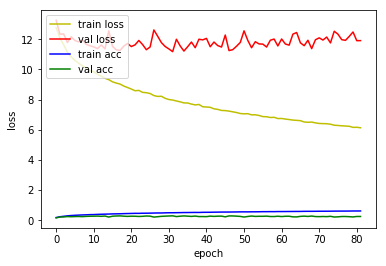

4815/4815 [==============================] - 3s 586us/sample - loss: 11.5551 - acc: 0.2658
Loss: 11.555106499534283 Accuracy: 0.26583594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8488 - acc: 0.3043
Epoch 00001: val_loss improved from inf to 5.60108, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_BN_checkpoint/001-5.6011.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 4.8487 - acc: 0.3043 - val_loss: 5.6011 - val_acc: 0.2369
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6018 - acc: 0.5844
Epoch 00002: val_loss improved from 5.60108 to 5.38353, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_BN_checkpoint/002-5.3835.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 2.6018 - acc: 0.5843 - val_loss: 5.3835 - val_acc: 0.3317
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3839 - acc: 0.9595
Epoch 00029: val_loss did not improve from 5.24994
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.3842 - acc: 0.9594 - val_loss: 8.6330 - val_acc: 0.3247
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3619 - acc: 0.9633
Epoch 00030: val_loss did not improve from 5.24994
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.3626 - acc: 0.9632 - val_loss: 8.0753 - val_acc: 0.3699
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3601 - acc: 0.9635
Epoch 00031: val_loss did not improve from 5.24994
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.3600 - acc: 0.9635 - val_loss: 9.4253 - val_acc: 0.2958
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3458 - acc: 0.9664
Epoch 00032: val_loss did not improve from 5.24994
36805/36805 [========================

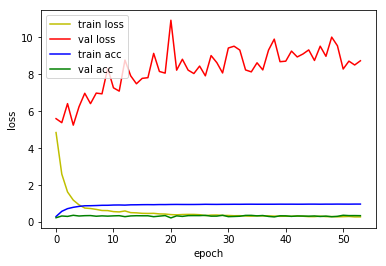

4815/4815 [==============================] - 4s 755us/sample - loss: 5.5994 - acc: 0.3310
Loss: 5.599392885384406 Accuracy: 0.33104882

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5463 - acc: 0.3876
Epoch 00001: val_loss improved from inf to 1.96366, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_BN_checkpoint/001-1.9637.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.5461 - acc: 0.3876 - val_loss: 1.9637 - val_acc: 0.4237
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1948 - acc: 0.6704
Epoch 00002: val_loss did not improve from 1.96366
36805/36805 [==============================] - 80s 2ms/sample - loss: 1.1949 - acc: 0.6703 - val_loss: 2.6872 - val_acc: 0.4100
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6104 - acc: 0.8286
Epoch 00003: val_loss did not improve from 1.96366
36805/36805 [=============

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9862
Epoch 00030: val_loss did not improve from 1.96366
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0690 - acc: 0.9861 - val_loss: 4.0625 - val_acc: 0.4980
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9878
Epoch 00031: val_loss did not improve from 1.96366
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0592 - acc: 0.9878 - val_loss: 4.3911 - val_acc: 0.4719
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9914
Epoch 00032: val_loss did not improve from 1.96366
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0487 - acc: 0.9914 - val_loss: 4.4801 - val_acc: 0.4645
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0539 - acc: 0.9908
Epoch 00033: val_loss did not improve from 1.96366
36805/36805 [===========

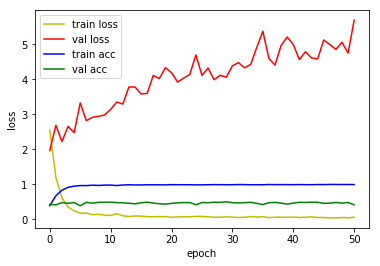

4815/4815 [==============================] - 4s 818us/sample - loss: 2.0527 - acc: 0.3909
Loss: 2.052732032976913 Accuracy: 0.3908619

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9660 - acc: 0.4304
Epoch 00001: val_loss improved from inf to 1.61258, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/001-1.6126.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.9661 - acc: 0.4304 - val_loss: 1.6126 - val_acc: 0.4759
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1906 - acc: 0.6405
Epoch 00002: val_loss improved from 1.61258 to 1.48192, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/002-1.4819.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.1908 - acc: 0.6404 - val_loss: 1.4819 - val_acc: 0.5642
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8

36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9953
Epoch 00029: val_loss did not improve from 1.42458
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0308 - acc: 0.9952 - val_loss: 2.1697 - val_acc: 0.6091
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0364 - acc: 0.9936
Epoch 00030: val_loss did not improve from 1.42458
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0365 - acc: 0.9935 - val_loss: 2.0595 - val_acc: 0.6287
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9910
Epoch 00031: val_loss did not improve from 1.42458
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0466 - acc: 0.9910 - val_loss: 2.0991 - val_acc: 0.6215
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9934
Epoch 00032: val_loss did not improve from 1.42458
36805/36805 [========================

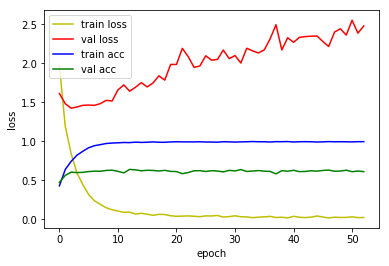

4815/4815 [==============================] - 4s 898us/sample - loss: 1.5135 - acc: 0.5753
Loss: 1.5135260522303675 Accuracy: 0.57528555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7764 - acc: 0.4745
Epoch 00001: val_loss improved from inf to 1.48514, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/001-1.4851.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.7765 - acc: 0.4744 - val_loss: 1.4851 - val_acc: 0.5420
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1598 - acc: 0.6528
Epoch 00002: val_loss improved from 1.48514 to 1.28976, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/002-1.2898.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.1598 - acc: 0.6527 - val_loss: 1.2898 - val_acc: 0.6240
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9936
Epoch 00029: val_loss did not improve from 1.10456
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0389 - acc: 0.9936 - val_loss: 1.5822 - val_acc: 0.6823
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9915
Epoch 00030: val_loss did not improve from 1.10456
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0442 - acc: 0.9915 - val_loss: 1.5074 - val_acc: 0.6895
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9965
Epoch 00031: val_loss did not improve from 1.10456
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0263 - acc: 0.9965 - val_loss: 1.5843 - val_acc: 0.6858
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9951
Epoch 00032: val_loss did not improve from 1.10456
36805/36805 [===========

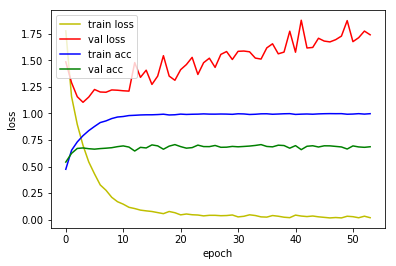

4815/4815 [==============================] - 5s 943us/sample - loss: 1.1865 - acc: 0.6503
Loss: 1.186473771456246 Accuracy: 0.6502596

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7821 - acc: 0.4593
Epoch 00001: val_loss improved from inf to 1.53208, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/001-1.5321.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 1.7820 - acc: 0.4593 - val_loss: 1.5321 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1466 - acc: 0.6527
Epoch 00002: val_loss improved from 1.53208 to 1.13952, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/002-1.1395.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.1467 - acc: 0.6526 - val_loss: 1.1395 - val_acc: 0.6576
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

36800/36805 [============================>.] - ETA: 0s - loss: 0.0833 - acc: 0.9851
Epoch 00027: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0835 - acc: 0.9850 - val_loss: 0.9989 - val_acc: 0.7494
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0969 - acc: 0.9793
Epoch 00028: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0970 - acc: 0.9792 - val_loss: 0.8910 - val_acc: 0.7787
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0829 - acc: 0.9829
Epoch 00029: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0831 - acc: 0.9829 - val_loss: 0.8624 - val_acc: 0.7911
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0730 - acc: 0.9869
Epoch 00030: val_loss did not improve from 0.77350
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0336 - acc: 0.9947 - val_loss: 1.1603 - val_acc: 0.7645
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9912
Epoch 00058: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0435 - acc: 0.9912 - val_loss: 0.9685 - val_acc: 0.7962
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9919
Epoch 00059: val_loss did not improve from 0.77350
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.0401 - acc: 0.9919 - val_loss: 1.1708 - val_acc: 0.7622
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9927
Epoch 00060: val_loss did not improve from 0.77350
36805/36805 [===========

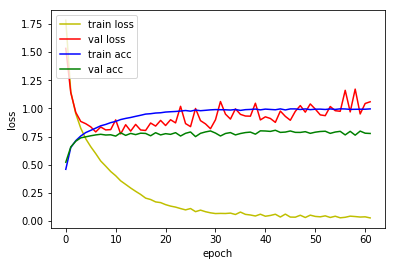

4815/4815 [==============================] - 5s 986us/sample - loss: 0.8476 - acc: 0.7547
Loss: 0.8476158900424328 Accuracy: 0.7547248

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8405 - acc: 0.4351
Epoch 00001: val_loss improved from inf to 1.64323, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/001-1.6432.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 1.8404 - acc: 0.4351 - val_loss: 1.6432 - val_acc: 0.4920
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1400 - acc: 0.6583
Epoch 00002: val_loss improved from 1.64323 to 0.97502, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/002-0.9750.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.1401 - acc: 0.6583 - val_loss: 0.9750 - val_acc: 0.7191
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0988 - acc: 0.9770
Epoch 00027: val_loss improved from 0.39812 to 0.39392, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/027-0.3939.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0988 - acc: 0.9770 - val_loss: 0.3939 - val_acc: 0.8945
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9792
Epoch 00028: val_loss did not improve from 0.39392
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0910 - acc: 0.9792 - val_loss: 0.4026 - val_acc: 0.8894
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9774
Epoch 00029: val_loss did not improve from 0.39392
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0934 - acc: 0.9774 - val_loss: 0.4623 - val_acc: 0.8805
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.39392
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0298 - acc: 0.9940 - val_loss: 0.4971 - val_acc: 0.8861
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9889
Epoch 00057: val_loss did not improve from 0.39392
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0468 - acc: 0.9889 - val_loss: 0.4607 - val_acc: 0.8915
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9943
Epoch 00058: val_loss did not improve from 0.39392
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0296 - acc: 0.9943 - val_loss: 0.4231 - val_acc: 0.8998
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9935
Epoch 00059: val_loss did not improve from 0.39392
36805/36805 [========================

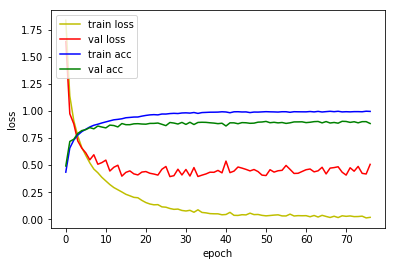

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4544 - acc: 0.8690
Loss: 0.45440640090534373 Accuracy: 0.8689512

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7953 - acc: 0.4538
Epoch 00001: val_loss improved from inf to 1.50552, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/001-1.5055.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.7952 - acc: 0.4539 - val_loss: 1.5055 - val_acc: 0.5406
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9854 - acc: 0.7130
Epoch 00002: val_loss improved from 1.50552 to 0.80549, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/002-0.8055.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.9854 - acc: 0.7130 - val_loss: 0.8055 - val_acc: 0.7750
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9851
Epoch 00025: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0630 - acc: 0.9851 - val_loss: 0.2552 - val_acc: 0.9290
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0614 - acc: 0.9857
Epoch 00026: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0614 - acc: 0.9857 - val_loss: 0.2367 - val_acc: 0.9357
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9911
Epoch 00027: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0445 - acc: 0.9911 - val_loss: 0.2417 - val_acc: 0.9285
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9895
Epoch 00028: val_loss did not improve from 0.22694
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9979
Epoch 00055: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0126 - acc: 0.9979 - val_loss: 0.2349 - val_acc: 0.9408
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9980
Epoch 00056: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0115 - acc: 0.9980 - val_loss: 0.2713 - val_acc: 0.9345
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9965
Epoch 00057: val_loss did not improve from 0.22694
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0162 - acc: 0.9965 - val_loss: 0.2595 - val_acc: 0.9327
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9985
Epoch 00058: val_loss did not improve from 0.22694
36805/36805 [===========

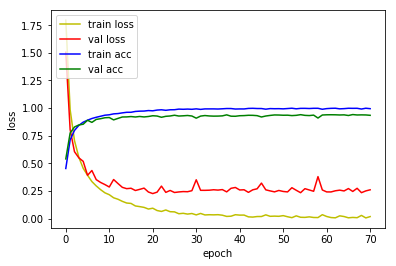

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2738 - acc: 0.9155
Loss: 0.2737742077400627 Accuracy: 0.9154725

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3793 - acc: 0.5769
Epoch 00001: val_loss improved from inf to 1.11048, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/001-1.1105.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 1.3793 - acc: 0.5769 - val_loss: 1.1105 - val_acc: 0.6546
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5933 - acc: 0.8234
Epoch 00002: val_loss improved from 1.11048 to 0.47204, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/002-0.4720.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.5933 - acc: 0.8234 - val_loss: 0.4720 - val_acc: 0.8598
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9929
Epoch 00026: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0305 - acc: 0.9929 - val_loss: 0.2073 - val_acc: 0.9469
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9976
Epoch 00027: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0160 - acc: 0.9976 - val_loss: 0.2588 - val_acc: 0.9297
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9954
Epoch 00028: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0214 - acc: 0.9954 - val_loss: 0.2111 - val_acc: 0.9464
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9965
Epoch 00029: val_loss did not improve from 0.18684
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9975
Epoch 00056: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0110 - acc: 0.9974 - val_loss: 0.4151 - val_acc: 0.9094
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9923
Epoch 00057: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0269 - acc: 0.9923 - val_loss: 0.2049 - val_acc: 0.9506
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9990
Epoch 00058: val_loss did not improve from 0.18684
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0055 - acc: 0.9990 - val_loss: 0.2081 - val_acc: 0.9529
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9994
Epoch 00059: val_loss did not improve from 0.18684
36805/36805 [===========

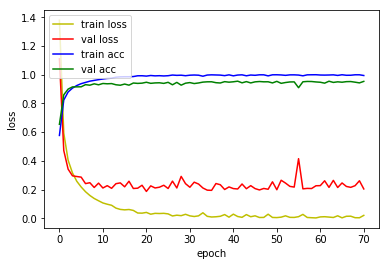

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2483 - acc: 0.9302
Loss: 0.24828713260830873 Accuracy: 0.93021804



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,480,528
Trainable params: 18,432,400
Non-trainable params: 2,048,128
__________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.5135 - acc: 0.5753
Loss: 1.5135260522303675 Accuracy: 0.57528555

1D_CNN_5_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4544 - acc: 0.8690
Loss: 0.45440640090534373 Accuracy: 0.8689512

1D_CNN_8_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2483 - acc: 0.9302
Loss: 0.24828713260830873 Accuracy: 0.93021804
